In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
DATA_DIR = pathlib.Path("data")

# Loading data

In [5]:
df = pd.read_csv("data/AEP_hourly.csv.zip", parse_dates=["Datetime"], index_col="Datetime")

In [6]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


## Fix timestamps

In [7]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [8]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [9]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [10]:
df[~df.index.duplicated(keep='first')]

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [11]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [12]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

### Missing values

In [13]:
dfi.isnull().mean()

AEP_MW    0.000223
dtype: float64

In [14]:
dfi.ffill(inplace=True)

# DalaModule

In [15]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [16]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values),
                torch.Tensor(fct_data[self.col].values))

In [17]:
ds = ElectricityDataset(dfi, 10)

In [18]:
start_ts = ds.sample_idx[4]

In [19]:
dfi[start_ts:].head()

,AEP_MW
2012-09-22 21:00:00,13599.0
2012-09-22 22:00:00,13129.0
2012-09-22 23:00:00,12416.0
2012-09-23 00:00:00,11661.0
2012-09-23 01:00:00,11033.0


In [20]:
dfi[start_ts+pd.Timedelta(days=7):].head()

,AEP_MW
2012-09-29 21:00:00,13065.0
2012-09-29 22:00:00,12793.0
2012-09-29 23:00:00,12104.0
2012-09-30 00:00:00,11373.0
2012-09-30 01:00:00,10858.0


In [21]:
ds[4]

(tensor([13599., 13129., 12416., 11661., 11033., 10566., 10479., 10336., 10405.,
         10477., 10851., 11176., 11776., 12122., 12208., 12277., 12454., 12426.,
         12368., 12351., 12393., 12569., 12707., 13235., 13629., 13334., 12452.,
         11860., 11454., 11129., 11108., 11193., 11436., 12240., 13845., 14688.,
         14843., 14851., 14802., 14790., 14650., 14583., 14497., 14378., 14313.,
         14259., 14206., 14540., 14997., 14547., 13621., 12597., 12006., 11608.,
         11519., 11480., 11650., 12447., 13991., 14661., 14657., 14723., 14860.,
         14725., 14800., 14831., 14862., 14689., 14704., 14641., 14645., 15060.,
         15158., 14727., 13760., 12915., 12192., 11775., 11586., 11520., 11619.,
         12360., 13825., 14679., 14700., 14906., 15070., 15252., 15319., 15399.,
         15412., 15378., 15491., 15415., 15268., 15703., 15887., 15071., 14085.,
         13123., 12429., 11806., 11623., 11515., 11751., 12352., 13803., 14599.,
         14749., 14941., 153

In [22]:
class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

# Encoder network

In [23]:
class ElectricityEncoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.encoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)

    def forward(self, x):
        output, (henc, cenc) = self.encoder(x.view(x.shape[0], x.shape[1], 1))
        
        return output, henc, cenc

In [24]:
encoder = ElectricityEncoder()

In [25]:
hist_sample = torch.cat([ds[3][0].unsqueeze(0),
                         ds[5][0].unsqueeze(0)])

fct_sample = torch.cat([ds[3][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

output, hc, cc = encoder(hist_sample)

In [26]:
hist_sample.shape

torch.Size([2, 168])

In [27]:
hc.shape

torch.Size([1, 2, 8])

In [28]:
output.shape

torch.Size([2, 168, 8])

In [29]:
cc.shape

torch.Size([1, 2, 8])

# Decoder network

In [30]:
class ElectricityDecoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.decoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.linear = nn.Linear(self.hidden_units, 1)

    def forward(self, x, hidden):
        output, (hc, cc) = self.decoder(x.view(x.shape[0], x.shape[1], 1), hidden)
        output = self.linear(output.squeeze(1))
        return output, hc, cc

In [31]:
decoder = ElectricityDecoder()

In [32]:
a, b, c = decoder(hist_sample[:, [-1]], (hc, cc))

In [33]:
decoder(a, (b, c))

(tensor([[0.0051],
         [0.0051]], grad_fn=<AddmmBackward>),
 tensor([[[-0.6374,  0.0103, -0.0351,  0.0029,  0.1253,  0.0685,  0.3185,
            0.0615],
          [-0.6374,  0.0103, -0.0351,  0.0029,  0.1253,  0.0685,  0.3185,
            0.0615]]], grad_fn=<StackBackward>),
 tensor([[[-6.7601e+01,  2.0463e-02, -6.8850e-02,  5.0359e-03,  3.3126e-01,
            1.4689e-01,  4.8338e-01,  1.5731e-01],
          [-6.7601e+01,  2.0463e-02, -6.8850e-02,  5.0359e-03,  3.3126e-01,
            1.4689e-01,  4.8338e-01,  1.5731e-01]]], grad_fn=<StackBackward>))

In [34]:
a.shape

torch.Size([2, 1])

# Encoder-decoder model

In [40]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.encoder = ElectricityEncoder(hist_len, fct_len, num_layers, hidden_units)
        self.decoder = ElectricityDecoder(hist_len, fct_len, num_layers, hidden_units)

    def forward(self, x):
        forecasts = []
        enc, hh, cc = self.encoder(x)
        enc = x[:, [-1]]

        for i in range(self.fct_len):
            enc, hc, cc = self.decoder(enc, (hh, cc))
            forecasts.append(enc)
        forecasts = torch.cat(forecasts, dim=1)
        return forecasts

    def training_step(self, batch, batch_idx):
        x, y = batch
        fct = self(x)
        return F.mse_loss(fct, y)

    def validation_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Scaling

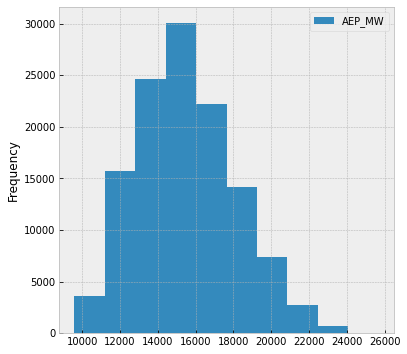

In [36]:
plt.figure(figsize=(6,6))
dfi.plot(kind="hist", ax=plt.gca())

In [37]:
LIMH, LIML =26e3, 9e3

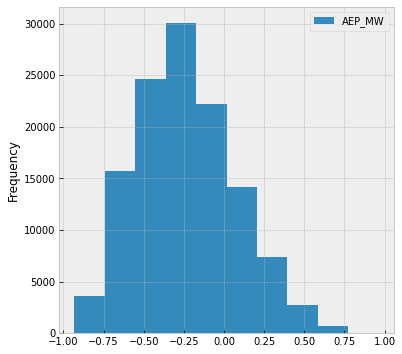

In [38]:
plt.figure(figsize=(6,6))
((2 * dfi - LIML - LIMH) / (LIMH - LIML)).plot(kind="hist", ax=plt.gca())

In [49]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)

ds = ElectricityDataModule(dfs, batch_size=32)
model = ElectricityModel(lr=1e-3, hidden_units=64)
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(model, ds)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ElectricityEncoder | 17.2 K
1 | decoder | ElectricityDecoder | 17.2 K
-----------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params


1

In [55]:
hist_sample_scaled = (2 * hist_sample - LIML - LIMH) / (LIMH - LIML)

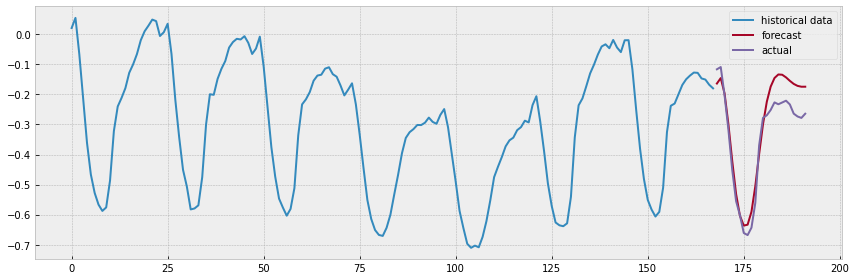

In [57]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[0], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="actual")

plt.legend(loc=0)
plt.tight_layout()

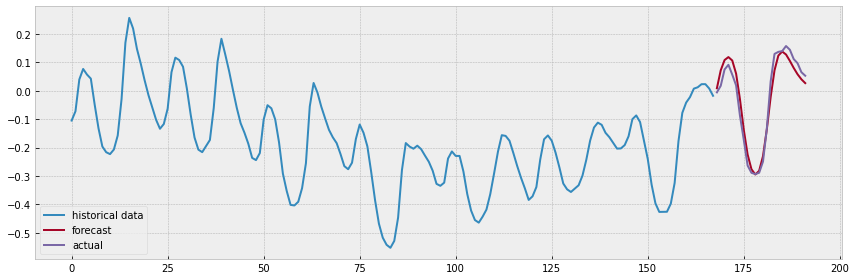

In [56]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[1], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="actual")

plt.legend(loc=0)
plt.tight_layout()

In [63]:
dl = ds.test_dataloader()

In [67]:
xx = x[0]

In [68]:
xx.cuda()

tensor([[-0.3912, -0.3532, -0.3101,  ..., -0.0629, -0.1262, -0.1402],
        [-0.2264, -0.2213, -0.2468,  ..., -0.3980, -0.3596, -0.3216],
        [-0.2419, -0.2532, -0.2686,  ..., -0.2001, -0.0420,  0.0122],
        ...,
        [-0.1664, -0.2128, -0.2764,  ..., -0.0026, -0.0719, -0.1381],
        [-0.6256, -0.6509, -0.6165,  ..., -0.3887, -0.4301, -0.4516],
        [-0.5846, -0.6566, -0.7086,  ..., -0.0381, -0.1613, -0.2978]],
       device='cuda:0')

In [70]:
for x in dl:
    fct = model(x[0].cuda())
    break

In [76]:
fct = fct.detach().cpu().numpy()

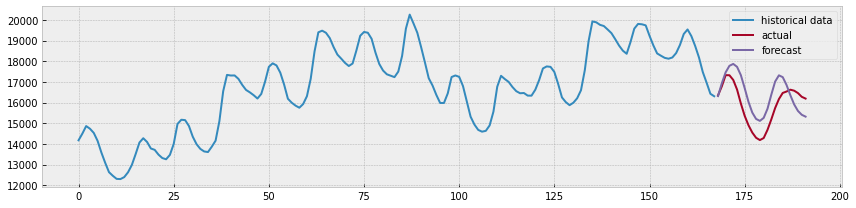

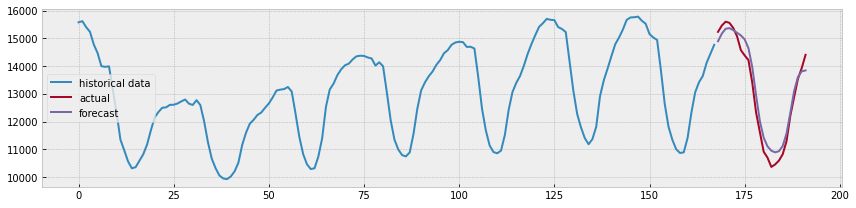

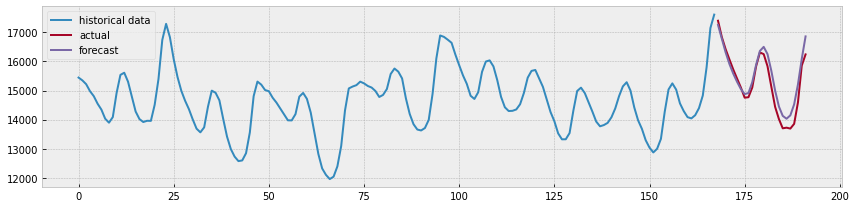

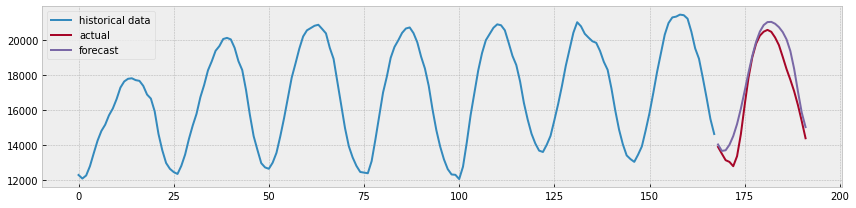

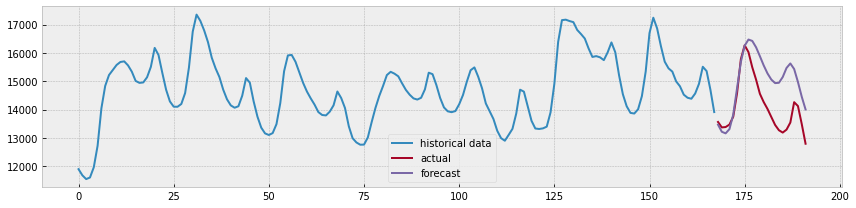

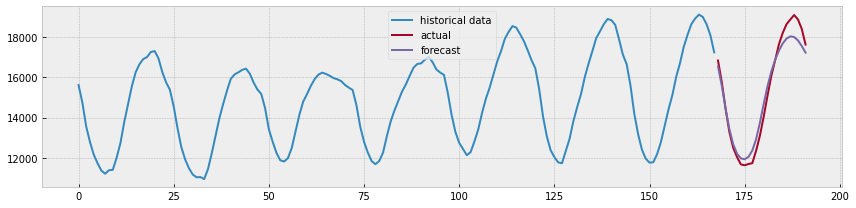

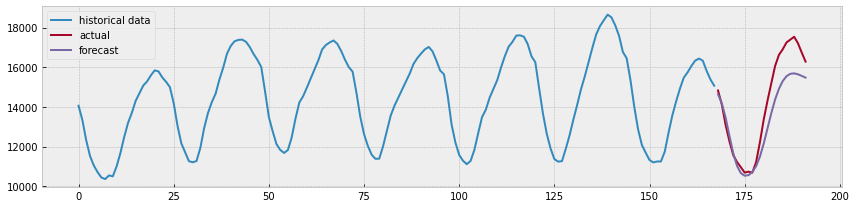

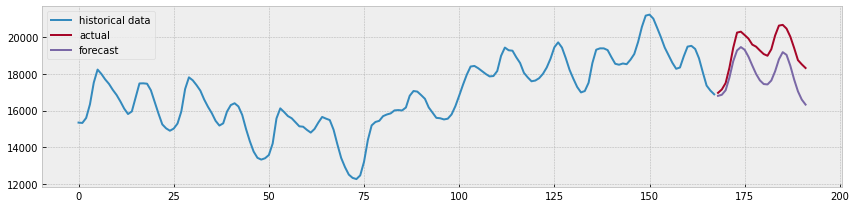

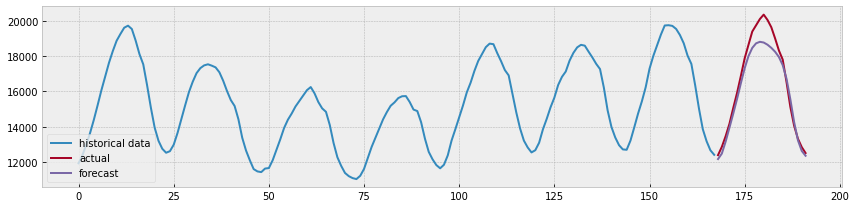

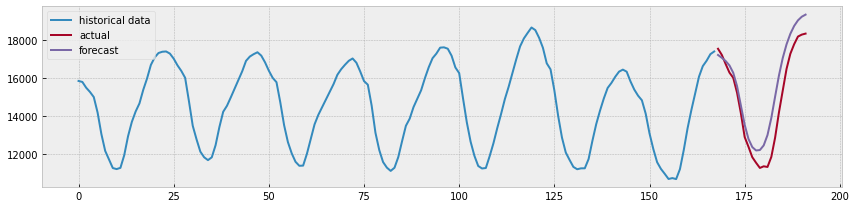

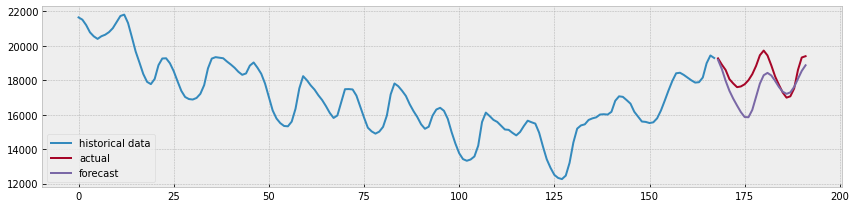

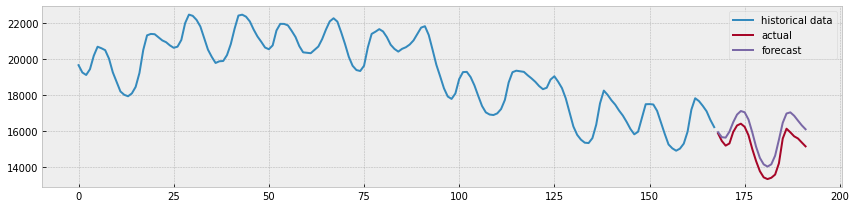

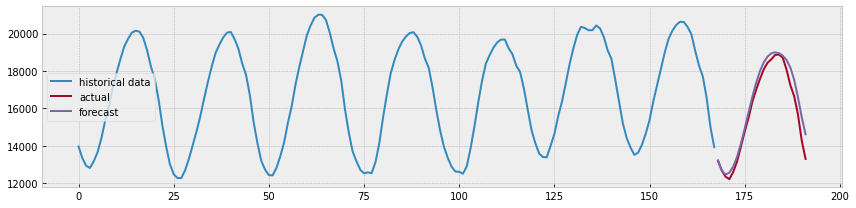

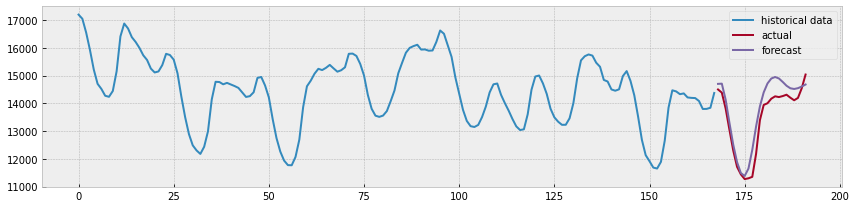

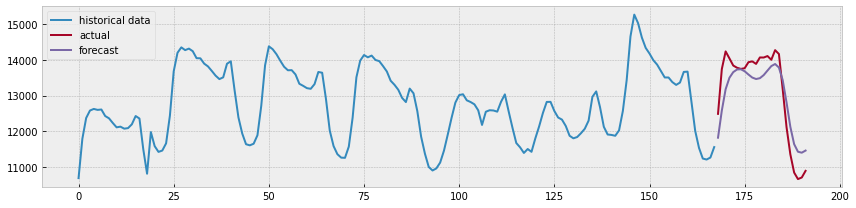

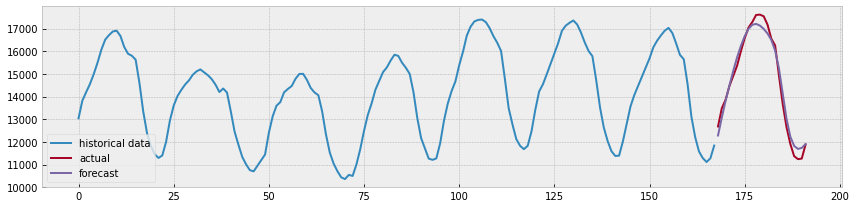

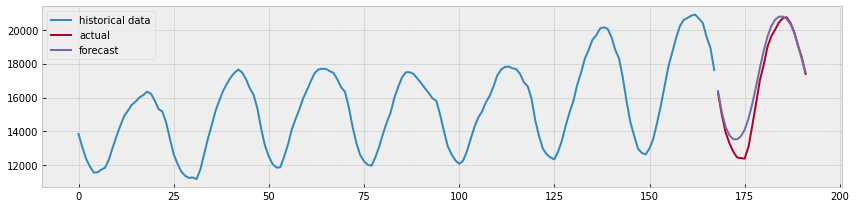

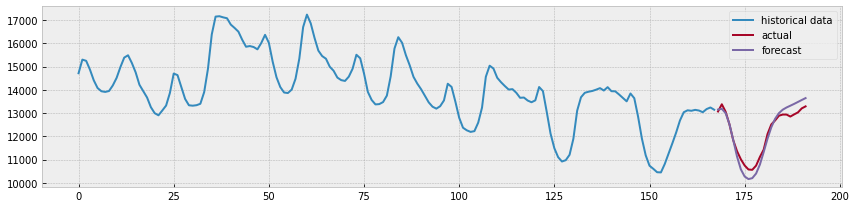

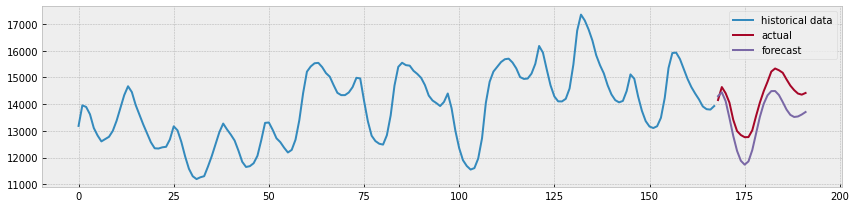

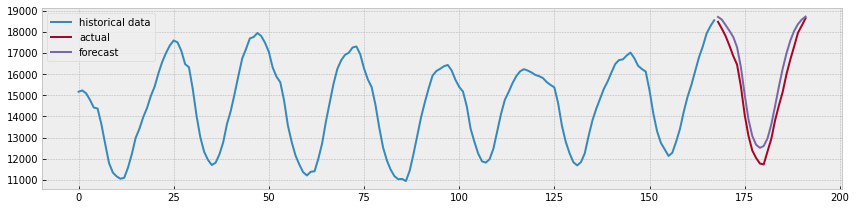

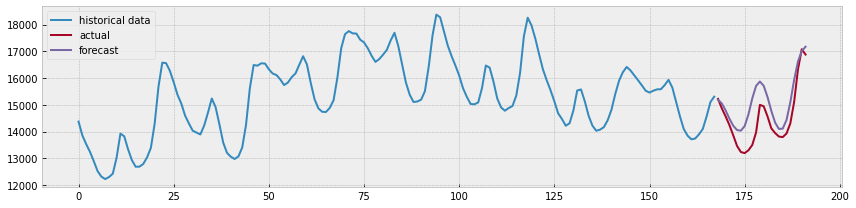

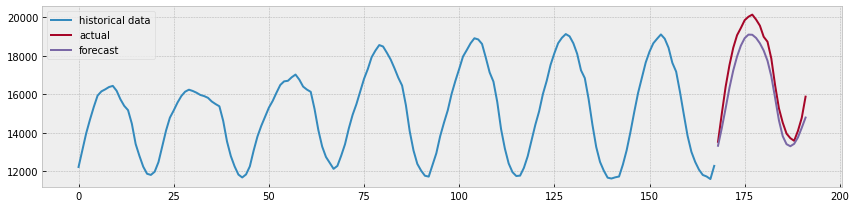

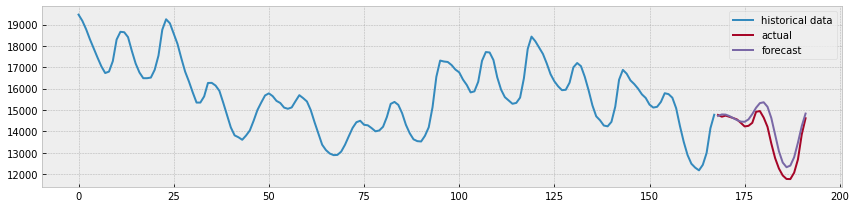

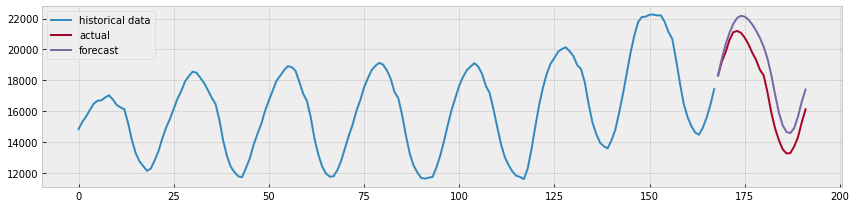

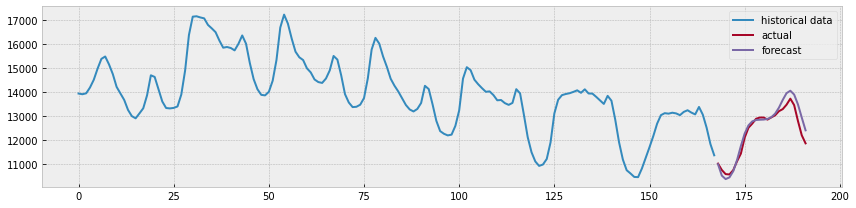

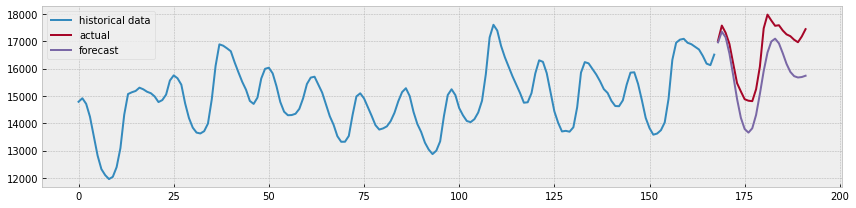

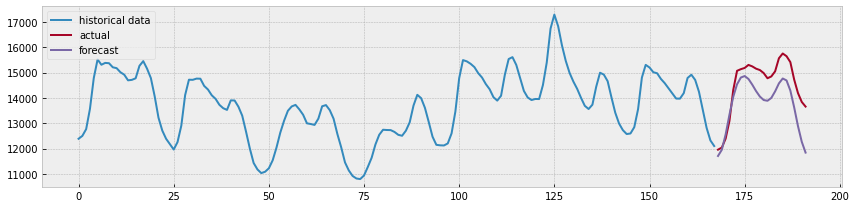

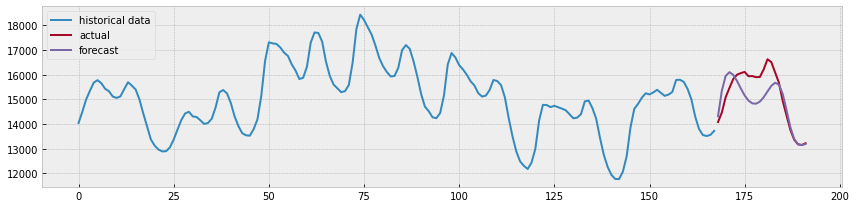

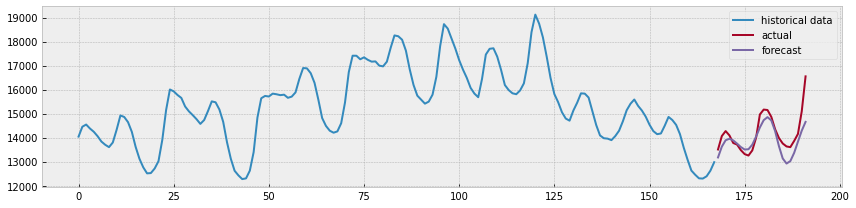

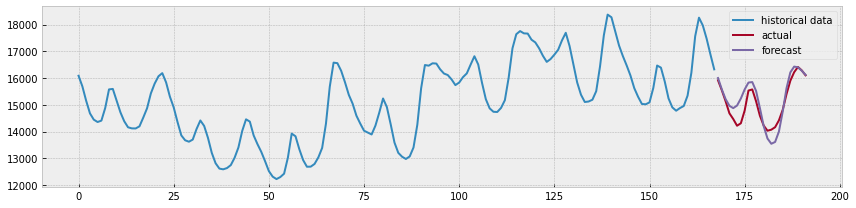

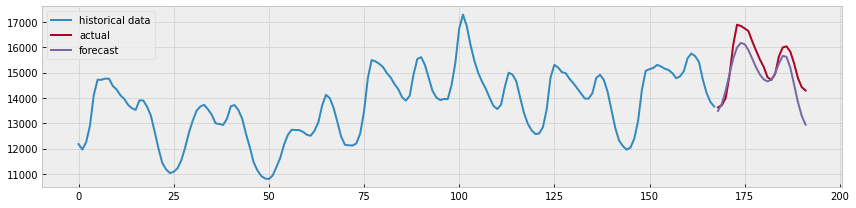

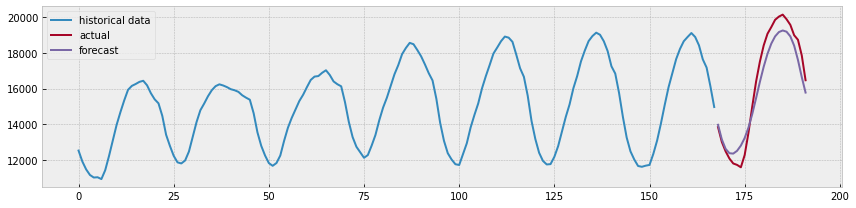

In [83]:
for stream in range(32):
    plt.figure(figsize=(12,3))
    plt.plot((x[0][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="historical data")
    plt.plot(np.arange(168, 192, 1), (x[1][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="actual")
    plt.plot(np.arange(168, 192, 1), (fct[stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="forecast")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()